In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import momepy
import networkx as nx
ox.__version__

'2.0.2'

In [2]:
import matplotlib.pyplot as plt
from libpysal import weights

In [3]:
from shapely.geometry import LineString, Point, MultiLineString

In [4]:
grt_routes = gpd.read_file('./data/GRT_Routes.geojson')

exploration

In [ ]:
grt_routes.tail()

In [ ]:
grt_routes[grt_routes['Route'] == 62]

In [ ]:
grt_routes.geometry

source for the following: https://stackoverflow.com/questions/51719465/get-intersections-of-all-linestrings-within-a-geodataframe-geopandas-in-python

In [6]:
line_df = gpd.GeoDataFrame(geometry=grt_routes.geometry)

In [7]:
#Create a dataframe of all line x and y coordinates
coords_pre_dissolve = line_df.get_coordinates()

In [8]:
coords_pre_dissolve

,x,y
0,-80.404142,43.389912
0,-80.403731,43.390167
0,-80.403696,43.390551
0,-80.404307,43.392354
0,-80.405337,43.392177
...,...,...
104,-80.393032,43.410415
104,-80.392978,43.410403
104,-80.392959,43.410398
104,-80.392902,43.410385


In [9]:
#Dissolve the line df into a one row multiline .
#  This will insert new vertices at all line intersections.
#  Extract them into a dataframe
coords_post_dissolve = line_df.dissolve().get_coordinates()

<Axes: >

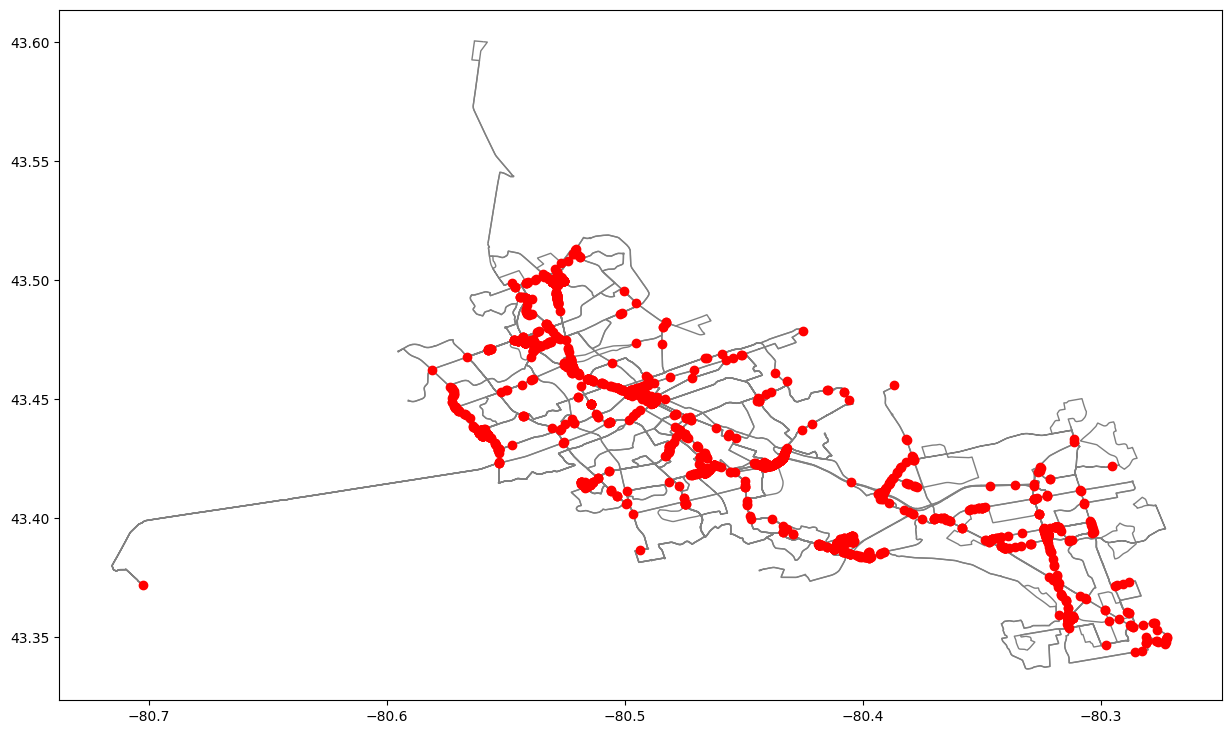

In [10]:
#Find new coordinates that are present in the multiline df but not in the original line df
intersections = coords_post_dissolve.merge(coords_pre_dissolve, 
                           on=["x","y"], how="left", indicator=True).query("_merge=='left_only'").drop_duplicates()

#Create a point geodataframe of the new coordinates
intersections = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=intersections.x, y=intersections.y))

ax = line_df.plot(figsize=(15,15), zorder=1, linewidth=1, color="gray")
intersections.plot(ax=ax, zorder=2, color="red")

intersections

merging the multilinestring objects into linestrings is needed for the following steps with networkx and momepy

In [11]:
from typing import Union
def multiline_to_single_line(geometry: Union[LineString, MultiLineString]) -> LineString:
  if isinstance(geometry, LineString):
      return geometry
  coords = list(map(lambda part: list(part.coords), geometry.geoms))
  flat_coords = [Point(*point) for segment in coords for point in segment]
  return LineString(flat_coords)

In [12]:
grt_routes['geometry'] = grt_routes.geometry.apply(multiline_to_single_line)

In [13]:
grt_routes['geometry']

0      LINESTRING Z (-80.40414 43.38991 0, -80.40373 ...
1      LINESTRING Z (-80.40373 43.39017 0, -80.4037 4...
2      LINESTRING Z (-80.32333 43.39353 0, -80.32386 ...
3      LINESTRING Z (-80.44131 43.3785 0, -80.44203 4...
4      LINESTRING Z (-80.44007 43.42253 0, -80.44 43....
                             ...                        
100    LINESTRING Z (-80.48824 43.44857 0, -80.48834 ...
101    LINESTRING Z (-80.3866 43.45593 0, -80.38676 4...
102    LINESTRING Z (-80.39258 43.41026 0, -80.39241 ...
103    LINESTRING Z (-80.54098 43.47393 0, -80.53906 ...
104    LINESTRING Z (-80.39258 43.41026 0, -80.39241 ...
Name: geometry, Length: 105, dtype: geometry

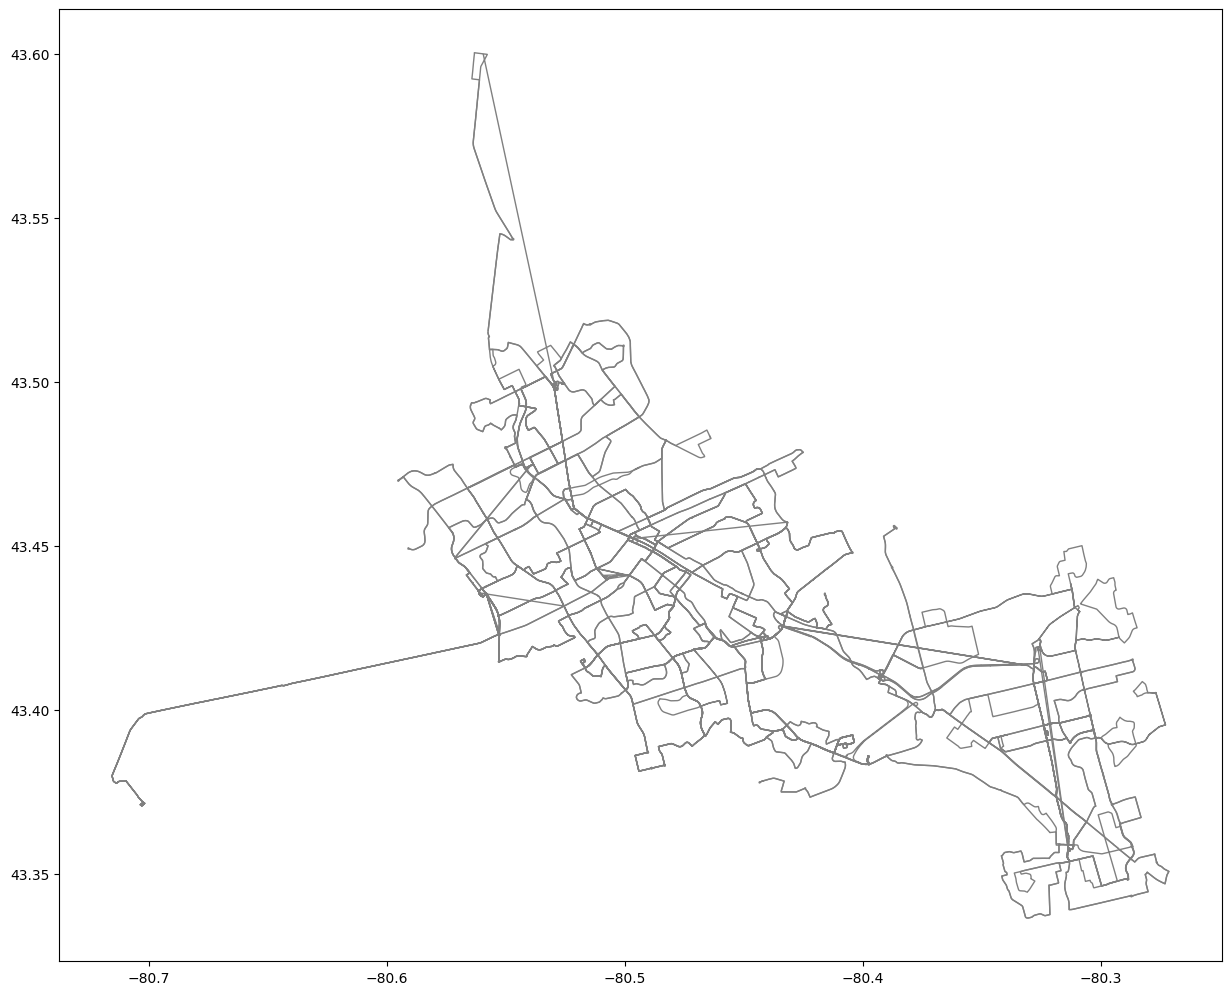

In [14]:
ax = grt_routes['geometry'].plot(figsize=(15,15), zorder=1, linewidth=1, color="gray")

networks

In [15]:
#https://docs.momepy.org/en/v0.8.1/user_guide/graph/convert.html
graph = momepy.gdf_to_nx(grt_routes, approach="primal")

/home/matt/v_env/housing-project/lib/python3.12/site-packages/momepy/utils.py:351: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


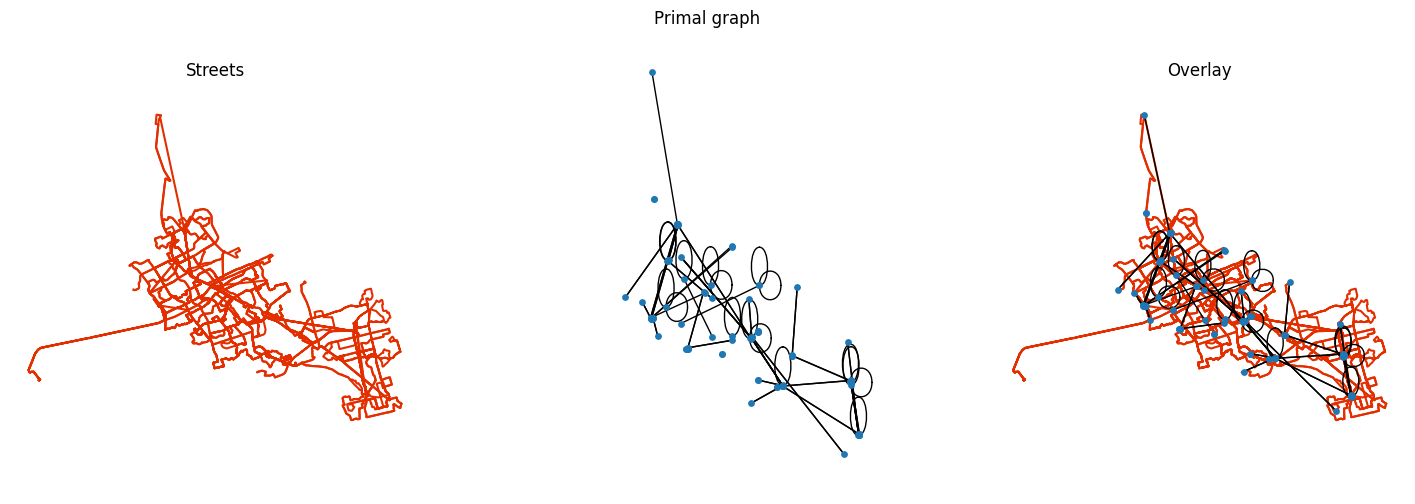

In [16]:
f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
grt_routes.plot(color="#e32e00", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[1], node_size=15
)
grt_routes.plot(color="#e32e00", ax=ax[2], zorder=-1)
nx.draw(
    graph, {n: [n[0], n[1]] for n in list(graph.nodes)}, ax=ax[2], node_size=15
)

In [ ]:
graph.nodes